## What files do I need?
You'll need train.csv, test.csv and sample_submission.csv.

## What should I expect the data format to be?
- Each sample in the train and test set has the following information:
- The text of a tweet
- A keyword from that tweet (although this may be blank!)
- The location the tweet was sent from (may also be blank)

## What am I predicting?
You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

## Files
- train.csv - the training set
- test.csv - the test set
- sample_submission.csv - a sample submission file in the correct format

## Columns
- id - a unique identifier for each tweet
- text - the text of the tweet
- location - the location the tweet was sent from (may be blank)
- keyword - a particular keyword from the tweet (may be blank)
- target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

# importing library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from nltk.tokenize import WordPunctTokenizer 
import string
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

Using TensorFlow backend.


# reading dataset

In [2]:
df_train = pd.read_csv(r'C:\Users\MOMOZZING\WorkSpace\kaggle\Real_or_Not\train.csv', dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv(r'C:\Users\MOMOZZING\WorkSpace\kaggle\Real_or_Not\test.csv', dtype={'id': np.int16})
df_sub = pd.read_csv(r'C:\Users\MOMOZZING\WorkSpace\kaggle\Real_or_Not\sample_submission.csv', dtype={'id': np.int16})

# data exploring&cleaning

In [3]:
df_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int16
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int8
dtypes: int16(1), int8(1), object(3)
memory usage: 200.9+ KB


In [5]:
df_train.shape

(7613, 5)

In [6]:
df_train['location'].value_counts()

USA                       104
New York                   71
United States              50
London                     45
Canada                     29
                         ... 
Saint Louis, Missouri       1
In a crazy genius mind      1
THE 6IX                     1
Eastlake, OH                1
Orange County, NY           1
Name: location, Length: 3341, dtype: int64

In [7]:
clean_df_train = df_train.dropna(axis=0)

In [8]:
clean_df_train.shape

(5080, 5)

In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
id          3263 non-null int16
keyword     3237 non-null object
location    2158 non-null object
text        3263 non-null object
dtypes: int16(1), object(3)
memory usage: 83.0+ KB


In [10]:
df_test.shape

(3263, 4)

In [11]:
clean_df_test = df_test.dropna(axis=0)

In [12]:
clean_df_test.shape

(2158, 4)

In [13]:
df_sub

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [14]:
df_sub['target'].value_counts()

0    3263
Name: target, dtype: int64

In [15]:
clean_df_train.head(30)

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
36,54,ablaze,Pretoria,@PhDSquares #mufc they've built so much hype a...,0
37,55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3...,1
39,57,ablaze,Paranaque City,Ablaze for you Lord :D,0
40,59,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
42,62,ablaze,milky way,Had an awesome time visiting the CFC head offi...,0


In [16]:
fire = clean_df_train[clean_df_train['keyword'] == 'fire']

In [17]:
fire

,id,keyword,location,text,target
3739,5315,fire,SÌ£o Paulo,Marquei como visto Game of Thrones - 3x5 - Kis...,0
3742,5319,fire,2 high 2 come down,@Miss_HoMaStToPa cause were on fire we are on ...,1
3744,5321,fire,Wrex,http://t.co/iNkuv5DNTX #auction #shoes Retro 5...,0
3746,5323,fire,big boy Û¢ 0802,I'm crying that song just ended setting myself...,0
3750,5328,fire,Brooklyn,But put 'Flood of Fire' at the top of the list...,1
3751,5330,fire,Canada,I'm On Fire. http://t.co/WATsmxYTVa,0
3752,5331,fire,To The Right of You!,Politifiact: Harry Reid's '30 Percent of Women...,0
3753,5332,fire,"St.Cloud, MN",Dear @CanonUSAimaging I brought it ;) #CanonBr...,0
3756,5337,fire,on a catwalk somewhere,Fire Meet Gasoline always gotta get played twi...,0
3757,5338,fire,å_,WCW @catsandsyrup THA BITCH IS FIRE,0


In [18]:
target_clean_df_train = clean_df_train.groupby('target').target.count()

In [19]:
target_clean_df_train


target
0    2884
1    2196
Name: target, dtype: int64

In [20]:
label = ['disaster', 'non_disaster']



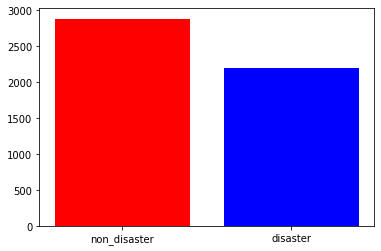

In [21]:
plt.bar(label[1],target_clean_df_train[0], color = 'r')
plt.bar(label[0],target_clean_df_train[1], color = 'b')
plt.show()

In [22]:
clean_df_train

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...,...
7575,10826,wrecked,TN,On the bright side I wrecked http://t.co/uEa0t...,0
7577,10829,wrecked,#NewcastleuponTyne #UK,@widda16 ... He's gone. You can relax. I thoug...,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0


이 예제 를 풀려면 텍스트에 대한 분류와 binary classification이 필요할 것 같다. 이 부분에서 공부를 해야할 것 같다. 
텍스트를 통한 KEYWORD분류도 가능할 것 같다. 

# URL 제거

In [23]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)


In [24]:
all_df=pd.concat([clean_df_train,clean_df_test])
all_df.shape

C:\Users\MOMOZZING\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(7238, 5)

In [25]:
all_df['text']=all_df['text'].apply(lambda x : remove_URL(x))

# HTML 태그 제거

In [26]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [27]:
all_df['text']=all_df['text'].apply(lambda x : remove_html(x))

# 구둣점 제거

In [28]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [29]:
all_df['text']=all_df['text'].apply(lambda x : remove_punct(x))

# 토큰화

In [30]:
print(all_df['text'])
print(type(all_df['text']))
text = all_df['text']

31                       bbcmtd Wholesale Markets ablaze 
32             We always try to bring the heavy metal RT 
33      AFRICANBAZE Breaking newsNigeria flag set abla...
34                      Crying out for more Set me ablaze
35      On plus side LOOK AT THE SKY LAST NIGHT IT WAS...
                              ...                        
3246    yakubOObs think he deactivated because his not...
3247    RT CNBC 3 words from Disney CEO Bob Iger wreck...
3248    Smackdown tyme this should put me in a good mo...
3249    thrillhho jsyk I havent stopped thinking abt r...
3250    stighefootball Begovic has been garbage He got...
Name: text, Length: 7238, dtype: object
<class 'pandas.core.series.Series'>


In [31]:
tokenizer = WordPunctTokenizer() 

text = all_df['text']

text_list = text.tolist()

temp_list = []
for text in text_list:
    temp_list.append(tokenizer.tokenize(text))

print(temp_list)

[['bbcmtd', 'Wholesale', 'Markets', 'ablaze'], ['We', 'always', 'try', 'to', 'bring', 'the', 'heavy', 'metal', 'RT'], ['AFRICANBAZE', 'Breaking', 'newsNigeria', 'flag', 'set', 'ablaze', 'in', 'Aba'], ['Crying', 'out', 'for', 'more', 'Set', 'me', 'ablaze'], ['On', 'plus', 'side', 'LOOK', 'AT', 'THE', 'SKY', 'LAST', 'NIGHT', 'IT', 'WAS', 'ABLAZE'], ['PhDSquares', 'mufc', 'theyve', 'built', 'so', 'much', 'hype', 'around', 'new', 'acquisitions', 'but', 'I', 'doubt', 'they', 'will', 'set', 'the', 'EPL', 'ablaze', 'this', 'season'], ['INEC', 'Office', 'in', 'Abia', 'Set', 'Ablaze'], ['Ablaze', 'for', 'you', 'Lord', 'D'], ['Check', 'these', 'out', 'nsfw'], ['Had', 'an', 'awesome', 'time', 'visiting', 'the', 'CFC', 'head', 'office', 'the', 'ancop', 'site', 'and', 'ablaze', 'Thanks', 'to', 'Tita', 'Vida', 'for', 'taking', 'care', 'of', 'us'], ['How', 'the', 'West', 'was', 'burned', 'Thousands', 'of', 'wildfires', 'ablaze', 'in', 'California', 'alone'], ['Check', 'these', 'out', 'nsfw'], ['First

# glove

In [32]:
def create_corpus(all_df):
    corpus=[]
    for clean_df_train in tqdm(all_df['text']):
        words=[word.lower() for word in word_tokenize(clean_df_train) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus
        
        

In [33]:
corpus=create_corpus(all_df)

100%|████████████████████████████████████████████████████████████████████████████| 7238/7238 [00:00<00:00, 9887.41it/s]


In [46]:
corpus

[['bbcmtd', 'wholesale', 'markets', 'ablaze'],
 ['we', 'always', 'try', 'bring', 'heavy', 'metal', 'rt'],
 ['africanbaze', 'breaking', 'newsnigeria', 'flag', 'set', 'ablaze', 'aba'],
 ['crying', 'set', 'ablaze'],
 ['on',
  'plus',
  'side',
  'look',
  'at',
  'the',
  'sky',
  'last',
  'night',
  'it',
  'was',
  'ablaze'],
 ['phdsquares',
  'mufc',
  'theyve',
  'built',
  'much',
  'hype',
  'around',
  'new',
  'acquisitions',
  'i',
  'doubt',
  'set',
  'epl',
  'ablaze',
  'season'],
 ['inec', 'office', 'abia', 'set', 'ablaze'],
 ['ablaze', 'lord', 'd'],
 ['check', 'nsfw'],
 ['had',
  'awesome',
  'time',
  'visiting',
  'cfc',
  'head',
  'office',
  'ancop',
  'site',
  'ablaze',
  'thanks',
  'tita',
  'vida',
  'taking',
  'care',
  'us'],
 ['how',
  'west',
  'burned',
  'thousands',
  'wildfires',
  'ablaze',
  'california',
  'alone'],
 ['check', 'nsfw'],
 ['first',
  'night',
  'retainers',
  'its',
  'quite',
  'weird',
  'better',
  'get',
  'used',
  'i',
  'wear',
 

In [34]:
embedding_dict={}
with open(r'C:\Users\MOMOZZING\WorkSpace\glove.6B\glove.6B.100d.txt','r', encoding = "utf-8") as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [35]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

all_df_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [36]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 15957


In [37]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec
            

100%|████████████████████████████████████████████████████████████████████████| 15957/15957 [00:00<00:00, 666399.58it/s]


In [38]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           1595800   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,638,105
Trainable params: 42,305
Non-trainable params: 1,595,800
_________________________________________________________________


In [42]:
train=all_df_pad[:clean_df_train.shape[0]]
test=all_df_pad[clean_df_train.shape[0]:]

In [43]:
X_train,X_test,y_train,y_test=train_test_split(train,clean_df_train['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (4318, 50)
Shape of Validation  (762, 50)


In [45]:
history=model.fit(X_train,y_train,batch_size=4,epochs=30,validation_data=(X_test,y_test),verbose=2)

Train on 4318 samples, validate on 762 samples
Epoch 1/30
 - 17s - loss: 0.5460 - accuracy: 0.7554 - val_loss: 0.4908 - val_accuracy: 0.7769
Epoch 2/30
 - 17s - loss: 0.5509 - accuracy: 0.7473 - val_loss: 0.4898 - val_accuracy: 0.7769
Epoch 3/30
 - 17s - loss: 0.5398 - accuracy: 0.7591 - val_loss: 0.4887 - val_accuracy: 0.7795
Epoch 4/30
 - 17s - loss: 0.5353 - accuracy: 0.7642 - val_loss: 0.4892 - val_accuracy: 0.7782
Epoch 5/30
 - 16s - loss: 0.5435 - accuracy: 0.7506 - val_loss: 0.4886 - val_accuracy: 0.7808
Epoch 6/30
 - 16s - loss: 0.5431 - accuracy: 0.7499 - val_loss: 0.4878 - val_accuracy: 0.7822
Epoch 7/30
 - 16s - loss: 0.5407 - accuracy: 0.7580 - val_loss: 0.4854 - val_accuracy: 0.7795
Epoch 8/30
 - 16s - loss: 0.5424 - accuracy: 0.7506 - val_loss: 0.4853 - val_accuracy: 0.7822
Epoch 9/30
 - 16s - loss: 0.5365 - accuracy: 0.7594 - val_loss: 0.4850 - val_accuracy: 0.7835
Epoch 10/30
 - 16s - loss: 0.5343 - accuracy: 0.7587 - val_loss: 0.4844 - val_accuracy: 0.7848
Epoch 11/30


https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove